<a href="https://colab.research.google.com/github/tansaurus/VCMI/blob/main/ADC_best_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Visual Transformer**

Training Visual Transformer on ADC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu May 16 00:46:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# 미래 버전의 Python 기능을 현재 버전에서 사용하도록 설정
from __future__ import print_function

# 데이터 조작 및 계산을 위한 라이브러리
import numpy as np
import pandas as pd

# 머신러닝 및 데이터 분석 라이브러리
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# 시각화 라이브러리
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torchvision.transforms.functional as TF

# 딥러닝 및 이미지 처리 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# 진행률 표시를 위한 라이브러리
from tqdm import tqdm

# 파일 및 디렉토리 작업을 위한 라이브러리
import os
import glob
import zipfile

# 기타
from itertools import chain
import random
from sklearn.metrics import confusion_matrix
import shutil


Training settings

* batch size는 한 번에 모델이 학습하는 데이터 샘플의 개수
* 1 epoch은 전체 데이터셋을 한 번 사용하여 학습한 것
* gamma는 학습률 스케줄러에서 주어진 간격마다 학습률을 조정하는 데 사용되는 매개변수
* seed는 데이터 세트를 랜덤하게 분할하거나 모델의 가중치를 초기화할 때 시드를 고정하면 매번 같은 방식으로 데이터를 분할하고 동일한 초기 가중치를 사용하여 모델을 시작할 수 있게 한다

In [ ]:
batch_size = 64
epochs = 100
lr = 1e-7
gamma = 0.8
seed = 30

seed_everything

여러 랜덤 수 생성 시스템의 시드를 고정하여 실험의 재현성을 보장하는 함수

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed)

In [ ]:
device = 'cuda'

# **Data Loader**

In [ ]:
import pandas as pd

train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/ADC/train/train_labels.csv')
valid_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/ADC/val/val_labels.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/VCMI/monomodal_HGG/ADC/test/test_labels.csv')

In [ ]:
class Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return img_path, image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = Dataset(train_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = Dataset(valid_data, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_dataset = Dataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **ViT**

In [ ]:
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])
def extract_features(model, data_loader):
    model.eval()
    features = []
    labels = []
    file_paths = []  # 파일 경로를 저장할 리스트
    with torch.no_grad():
        for file_path, images, targets in data_loader:
            images = images.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())  # 특성을 리스트에 추가
            labels.extend(targets.cpu().numpy())  # 라벨을 리스트에 추가
            file_paths.extend(file_path)  # 파일 경로를 리스트에 추가

    features = np.array(features)
    labels = np.array(labels)
    return file_paths, features, labels


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 147MB/s]


In [ ]:
num_classes = 2
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes).to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=40, gamma=gamma)

# **t-SNE Before Training**

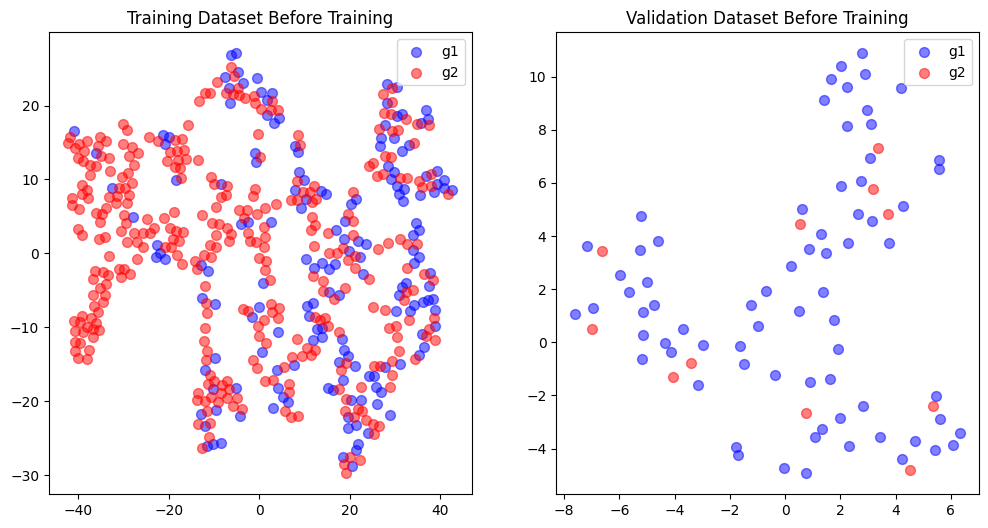

In [ ]:
# 훈련 및 검증 데이터셋의 특성 추출
train_paths, train_features, train_labels = extract_features(model, train_loader)
val_paths, val_features, val_labels = extract_features(model, valid_loader)

# 2차원 t-SNE 모델 생성 및 특성 축소
tsne_2d = TSNE(n_components=2, random_state=0, perplexity=20)
train_features_2d = tsne_2d.fit_transform(train_features)
val_features_2d = tsne_2d.fit_transform(val_features)

fig = plt.figure(figsize=(12, 6))

# 2차원 산점도 그리기 - 훈련 데이터셋
ax1 = fig.add_subplot(121)
ax1.scatter(train_features_2d[train_labels == 0, 0],
            train_features_2d[train_labels == 0, 1],
            s=50, c='blue', label='g1', alpha=0.5)
ax1.scatter(train_features_2d[train_labels == 1, 0],
            train_features_2d[train_labels == 1, 1],
            s=50, c='red', label='g2', alpha=0.5)
ax1.set_title('Training Dataset Before Training')
ax1.legend()

# 2차원 산점도 그리기 - 검증 데이터셋
ax2 = fig.add_subplot(122)
ax2.scatter(val_features_2d[val_labels == 0, 0],
            val_features_2d[val_labels == 0, 1],
            s=50, c='blue', label='g1', alpha=0.5)
ax2.scatter(val_features_2d[val_labels == 1, 0],
            val_features_2d[val_labels == 1, 1],
            s=50, c='red', label='g2', alpha=0.5)
ax2.set_title('Validation Dataset Before Training')
ax2.legend()

plt.show()

# **Train**

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train(model, train_loader, valid_loader, criterion, optimizer, scheduler=scheduler, epochs=epochs, save_file='model_state_dict.pth', target_class=1):
    best_sensitivity = 0
    best_val_loss = float('inf')
    best_model_state_dict = None

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for path, data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            label_one_hot = torch.nn.functional.one_hot(label, num_classes=num_classes).float()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label_one_hot)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = output.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

        train_accuracy = correct / total
        train_loss = epoch_loss / len(train_loader)

        model.eval()
        val_loss = 0
        correct = 0
        val_total = 0
        TP = 0
        FN = 0

        for path, data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            label_one_hot = torch.nn.functional.one_hot(label, num_classes=num_classes).float()
            output = model(data)
            loss = criterion(output, label_one_hot)
            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += label.size(0)
            correct += predicted.eq(label).sum().item()

            # Sensitivity for class '1'
            TP += (predicted.eq(target_class) & label.eq(target_class)).sum().item()
            FN += (predicted.ne(target_class) & label.eq(target_class)).sum().item()

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

        val_accuracy = correct / val_total
        val_loss /= len(valid_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step()

        if sensitivity > best_sensitivity or (sensitivity == best_sensitivity and val_loss < best_val_loss):
            best_sensitivity = sensitivity
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict().copy()
            print(f"Epoch {epoch+1}: Saving new best model with sensitivity {sensitivity:.4f}")

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Accuracy {train_accuracy:.4f}, Val Loss {val_loss:.4f}, Val Accuracy {val_accuracy:.4f}, Sensitivity {sensitivity:.4f}")
        print("lr: ", optimizer.param_groups[0]['lr'])

    if best_model_state_dict:
        model.load_state_dict(best_model_state_dict)
        torch.save(best_model_state_dict, save_file)

    return torch.load(save_file)


In [ ]:
model_state_dict = train(model = model,
                         train_loader = train_loader,
                         valid_loader = valid_loader,
                         criterion = criterion,
                         optimizer = optimizer)
model.load_state_dict(model_state_dict)

100%|██████████| 8/8 [00:17<00:00,  2.24s/it]


Epoch 1: Saving new best model with sensitivity 0.1818
Epoch 1: Train Loss 0.6779, Train Accuracy 0.5575, Val Loss 0.6678, Val Accuracy 0.7108, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:17<00:00,  2.21s/it]


Epoch 2: Train Loss 0.6681, Train Accuracy 0.5893, Val Loss 0.6701, Val Accuracy 0.6988, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:17<00:00,  2.25s/it]


Epoch 3: Train Loss 0.6604, Train Accuracy 0.6052, Val Loss 0.6729, Val Accuracy 0.6988, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Epoch 4: Train Loss 0.6530, Train Accuracy 0.6290, Val Loss 0.6757, Val Accuracy 0.6867, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.31s/it]


Epoch 5: Train Loss 0.6461, Train Accuracy 0.6448, Val Loss 0.6787, Val Accuracy 0.6867, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 6: Train Loss 0.6395, Train Accuracy 0.6647, Val Loss 0.6816, Val Accuracy 0.6627, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 7: Train Loss 0.6333, Train Accuracy 0.6746, Val Loss 0.6845, Val Accuracy 0.6627, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 8: Train Loss 0.6274, Train Accuracy 0.6865, Val Loss 0.6874, Val Accuracy 0.6506, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 9: Train Loss 0.6219, Train Accuracy 0.6964, Val Loss 0.6903, Val Accuracy 0.6265, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 10: Train Loss 0.6166, Train Accuracy 0.7044, Val Loss 0.6931, Val Accuracy 0.6265, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 11: Train Loss 0.6117, Train Accuracy 0.7123, Val Loss 0.6958, Val Accuracy 0.6265, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 12: Train Loss 0.6070, Train Accuracy 0.7202, Val Loss 0.6984, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 13: Train Loss 0.6025, Train Accuracy 0.7282, Val Loss 0.7010, Val Accuracy 0.6024, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


Epoch 14: Train Loss 0.5982, Train Accuracy 0.7401, Val Loss 0.7035, Val Accuracy 0.6024, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 15: Train Loss 0.5941, Train Accuracy 0.7421, Val Loss 0.7060, Val Accuracy 0.5904, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 16: Train Loss 0.5902, Train Accuracy 0.7361, Val Loss 0.7083, Val Accuracy 0.5783, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 17: Train Loss 0.5865, Train Accuracy 0.7421, Val Loss 0.7106, Val Accuracy 0.5663, Sensitivity 0.1818
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 18: Saving new best model with sensitivity 0.2727
Epoch 18: Train Loss 0.5829, Train Accuracy 0.7421, Val Loss 0.7128, Val Accuracy 0.5783, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 19: Train Loss 0.5794, Train Accuracy 0.7401, Val Loss 0.7148, Val Accuracy 0.5663, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 20: Train Loss 0.5761, Train Accuracy 0.7401, Val Loss 0.7168, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 21: Train Loss 0.5729, Train Accuracy 0.7421, Val Loss 0.7187, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 22: Train Loss 0.5697, Train Accuracy 0.7421, Val Loss 0.7206, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 23: Train Loss 0.5667, Train Accuracy 0.7480, Val Loss 0.7223, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 24: Train Loss 0.5637, Train Accuracy 0.7500, Val Loss 0.7239, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 25: Train Loss 0.5609, Train Accuracy 0.7540, Val Loss 0.7254, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 26: Train Loss 0.5580, Train Accuracy 0.7540, Val Loss 0.7269, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 27: Train Loss 0.5553, Train Accuracy 0.7540, Val Loss 0.7283, Val Accuracy 0.5422, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 28: Train Loss 0.5526, Train Accuracy 0.7560, Val Loss 0.7295, Val Accuracy 0.5422, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 29: Train Loss 0.5500, Train Accuracy 0.7579, Val Loss 0.7307, Val Accuracy 0.5422, Sensitivity 0.2727
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


Epoch 30: Saving new best model with sensitivity 0.3636
Epoch 30: Train Loss 0.5474, Train Accuracy 0.7659, Val Loss 0.7318, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 31: Train Loss 0.5448, Train Accuracy 0.7659, Val Loss 0.7328, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 32: Train Loss 0.5423, Train Accuracy 0.7679, Val Loss 0.7338, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 33: Train Loss 0.5398, Train Accuracy 0.7718, Val Loss 0.7346, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 34: Train Loss 0.5374, Train Accuracy 0.7718, Val Loss 0.7354, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 35: Train Loss 0.5350, Train Accuracy 0.7738, Val Loss 0.7361, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 36: Train Loss 0.5326, Train Accuracy 0.7738, Val Loss 0.7368, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 37: Train Loss 0.5302, Train Accuracy 0.7738, Val Loss 0.7373, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 38: Train Loss 0.5279, Train Accuracy 0.7738, Val Loss 0.7379, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 39: Train Loss 0.5256, Train Accuracy 0.7817, Val Loss 0.7383, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  1e-07


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 40: Train Loss 0.5233, Train Accuracy 0.7817, Val Loss 0.7387, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 41: Train Loss 0.5212, Train Accuracy 0.7837, Val Loss 0.7389, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 42: Train Loss 0.5194, Train Accuracy 0.7837, Val Loss 0.7391, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 43: Train Loss 0.5176, Train Accuracy 0.7837, Val Loss 0.7393, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 44: Train Loss 0.5158, Train Accuracy 0.7837, Val Loss 0.7395, Val Accuracy 0.5542, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 45: Train Loss 0.5140, Train Accuracy 0.7837, Val Loss 0.7396, Val Accuracy 0.5663, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 46: Train Loss 0.5123, Train Accuracy 0.7837, Val Loss 0.7397, Val Accuracy 0.5663, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 47: Train Loss 0.5105, Train Accuracy 0.7817, Val Loss 0.7397, Val Accuracy 0.5663, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 48: Train Loss 0.5088, Train Accuracy 0.7798, Val Loss 0.7397, Val Accuracy 0.5663, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 49: Train Loss 0.5070, Train Accuracy 0.7798, Val Loss 0.7397, Val Accuracy 0.5663, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 50: Train Loss 0.5053, Train Accuracy 0.7798, Val Loss 0.7397, Val Accuracy 0.5663, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 51: Train Loss 0.5036, Train Accuracy 0.7837, Val Loss 0.7397, Val Accuracy 0.5663, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 52: Train Loss 0.5018, Train Accuracy 0.7857, Val Loss 0.7396, Val Accuracy 0.5663, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 53: Train Loss 0.5001, Train Accuracy 0.7877, Val Loss 0.7395, Val Accuracy 0.5663, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 54: Train Loss 0.4984, Train Accuracy 0.7877, Val Loss 0.7394, Val Accuracy 0.5663, Sensitivity 0.3636
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 55: Train Loss 0.4967, Train Accuracy 0.7857, Val Loss 0.7392, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 56: Train Loss 0.4950, Train Accuracy 0.7857, Val Loss 0.7390, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 57: Train Loss 0.4933, Train Accuracy 0.7857, Val Loss 0.7388, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 58: Train Loss 0.4917, Train Accuracy 0.7857, Val Loss 0.7386, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 59: Train Loss 0.4900, Train Accuracy 0.7857, Val Loss 0.7384, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 60: Train Loss 0.4883, Train Accuracy 0.7917, Val Loss 0.7382, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 61: Train Loss 0.4867, Train Accuracy 0.7917, Val Loss 0.7379, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 62: Train Loss 0.4850, Train Accuracy 0.7897, Val Loss 0.7376, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 63: Train Loss 0.4834, Train Accuracy 0.7937, Val Loss 0.7373, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 64: Train Loss 0.4817, Train Accuracy 0.7937, Val Loss 0.7370, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 65: Train Loss 0.4801, Train Accuracy 0.7937, Val Loss 0.7367, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 66: Train Loss 0.4784, Train Accuracy 0.7937, Val Loss 0.7363, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 67: Train Loss 0.4768, Train Accuracy 0.7937, Val Loss 0.7360, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 68: Train Loss 0.4752, Train Accuracy 0.7956, Val Loss 0.7356, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 69: Train Loss 0.4736, Train Accuracy 0.7956, Val Loss 0.7352, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 70: Train Loss 0.4719, Train Accuracy 0.7976, Val Loss 0.7348, Val Accuracy 0.5542, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 71: Train Loss 0.4703, Train Accuracy 0.7996, Val Loss 0.7344, Val Accuracy 0.5663, Sensitivity 0.2727
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 72: Train Loss 0.4687, Train Accuracy 0.7996, Val Loss 0.7340, Val Accuracy 0.5663, Sensitivity 0.1818
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 73: Train Loss 0.4671, Train Accuracy 0.7996, Val Loss 0.7336, Val Accuracy 0.5663, Sensitivity 0.1818
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 74: Train Loss 0.4655, Train Accuracy 0.8016, Val Loss 0.7332, Val Accuracy 0.5663, Sensitivity 0.1818
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 75: Train Loss 0.4639, Train Accuracy 0.8016, Val Loss 0.7327, Val Accuracy 0.5663, Sensitivity 0.1818
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 76: Train Loss 0.4624, Train Accuracy 0.8016, Val Loss 0.7322, Val Accuracy 0.5663, Sensitivity 0.1818
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 77: Train Loss 0.4608, Train Accuracy 0.8016, Val Loss 0.7318, Val Accuracy 0.5663, Sensitivity 0.1818
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 78: Train Loss 0.4592, Train Accuracy 0.8036, Val Loss 0.7313, Val Accuracy 0.5783, Sensitivity 0.1818
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 79: Train Loss 0.4576, Train Accuracy 0.8056, Val Loss 0.7308, Val Accuracy 0.5783, Sensitivity 0.1818
lr:  8e-08


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 80: Train Loss 0.4561, Train Accuracy 0.8115, Val Loss 0.7303, Val Accuracy 0.5783, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 81: Train Loss 0.4546, Train Accuracy 0.8135, Val Loss 0.7299, Val Accuracy 0.5904, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 82: Train Loss 0.4533, Train Accuracy 0.8155, Val Loss 0.7295, Val Accuracy 0.6024, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 83: Train Loss 0.4521, Train Accuracy 0.8135, Val Loss 0.7291, Val Accuracy 0.6024, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 84: Train Loss 0.4508, Train Accuracy 0.8135, Val Loss 0.7287, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 85: Train Loss 0.4496, Train Accuracy 0.8135, Val Loss 0.7283, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 86: Train Loss 0.4484, Train Accuracy 0.8155, Val Loss 0.7279, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 87: Train Loss 0.4471, Train Accuracy 0.8135, Val Loss 0.7274, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 88: Train Loss 0.4459, Train Accuracy 0.8155, Val Loss 0.7270, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 89: Train Loss 0.4447, Train Accuracy 0.8155, Val Loss 0.7266, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 90: Train Loss 0.4434, Train Accuracy 0.8135, Val Loss 0.7262, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 91: Train Loss 0.4422, Train Accuracy 0.8135, Val Loss 0.7257, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 92: Train Loss 0.4410, Train Accuracy 0.8135, Val Loss 0.7253, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 93: Train Loss 0.4398, Train Accuracy 0.8115, Val Loss 0.7248, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


Epoch 94: Train Loss 0.4386, Train Accuracy 0.8135, Val Loss 0.7244, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 95: Train Loss 0.4374, Train Accuracy 0.8135, Val Loss 0.7239, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 96: Train Loss 0.4362, Train Accuracy 0.8155, Val Loss 0.7235, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 97: Train Loss 0.4350, Train Accuracy 0.8155, Val Loss 0.7230, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 98: Train Loss 0.4338, Train Accuracy 0.8155, Val Loss 0.7226, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


Epoch 99: Train Loss 0.4326, Train Accuracy 0.8155, Val Loss 0.7221, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


Epoch 100: Train Loss 0.4314, Train Accuracy 0.8155, Val Loss 0.7217, Val Accuracy 0.6145, Sensitivity 0.1818
lr:  6.4e-08


<All keys matched successfully>

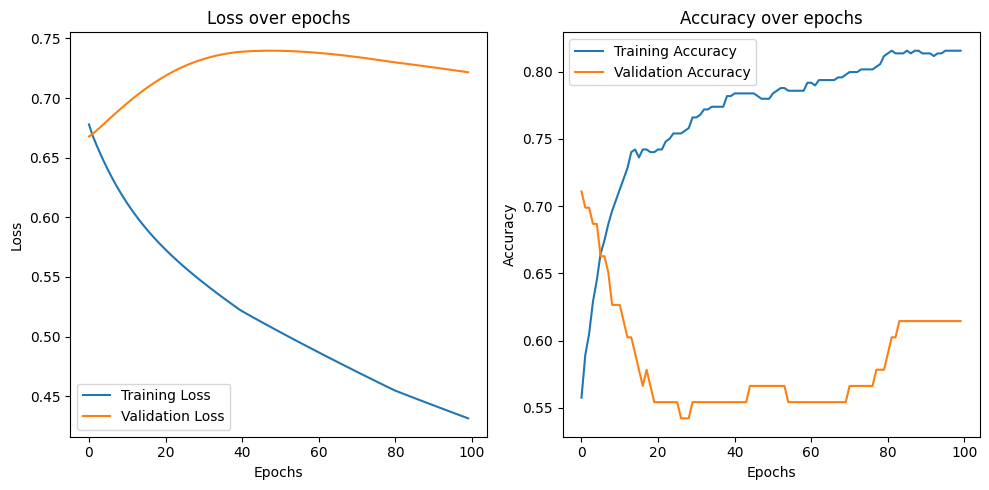

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# **t-SNE After Training**

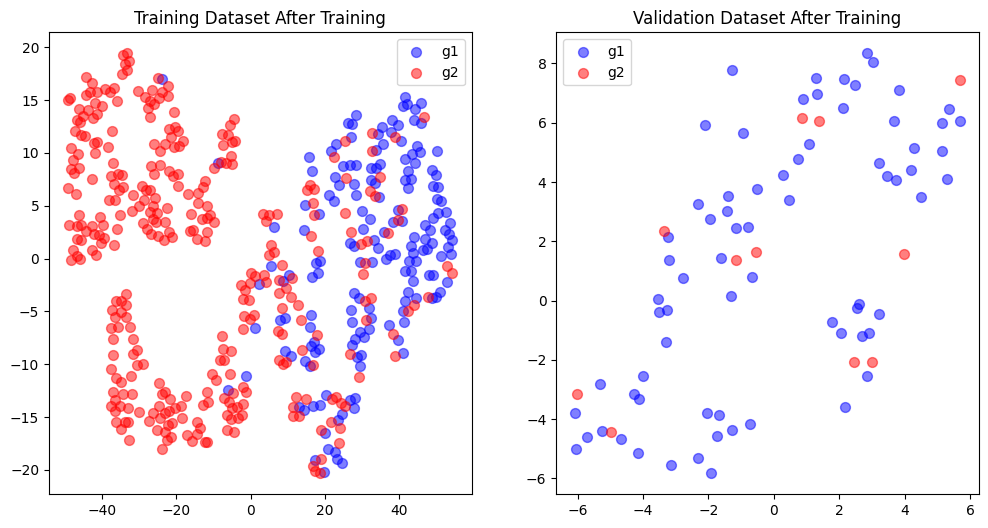

In [ ]:
# 모델 상태 사전 파일을 로드합니다.
model_state_dict = torch.load('model_state_dict.pth')

# 모델에 상태 사전을 로드합니다.
model.load_state_dict(model_state_dict)


# 훈련 및 검증 데이터셋의 특성 추출
train_paths, train_features, train_labels = extract_features(model, train_loader)
val_paths, val_features, val_labels = extract_features(model, valid_loader)

# 2차원 t-SNE 모델 생성 및 특성 축소
tsne_2d = TSNE(n_components=2, random_state=0, perplexity=20)
train_features_2d = tsne_2d.fit_transform(train_features)
val_features_2d = tsne_2d.fit_transform(val_features)

fig = plt.figure(figsize=(12, 6))

# 2차원 산점도 그리기 - 훈련 데이터셋
ax1 = fig.add_subplot(121)
ax1.scatter(train_features_2d[train_labels == 0, 0],
            train_features_2d[train_labels == 0, 1],
            s=50, c='blue', label='g1', alpha=0.5)
ax1.scatter(train_features_2d[train_labels == 1, 0],
            train_features_2d[train_labels == 1, 1],
            s=50, c='red', label='g2', alpha=0.5)
ax1.set_title('Training Dataset After Training')
ax1.legend()

# 2차원 산점도 그리기 - 검증 데이터셋
ax2 = fig.add_subplot(122)
ax2.scatter(val_features_2d[val_labels == 0, 0],
            val_features_2d[val_labels == 0, 1],
            s=50, c='blue', label='g1', alpha=0.5)
ax2.scatter(val_features_2d[val_labels == 1, 0],
            val_features_2d[val_labels == 1, 1],
            s=50, c='red', label='g2', alpha=0.5)
ax2.set_title('Validation Dataset After Training')
ax2.legend()

plt.show()


# **Test**

Accuracy for each class:
g1: 0.6500
g2: 0.5417


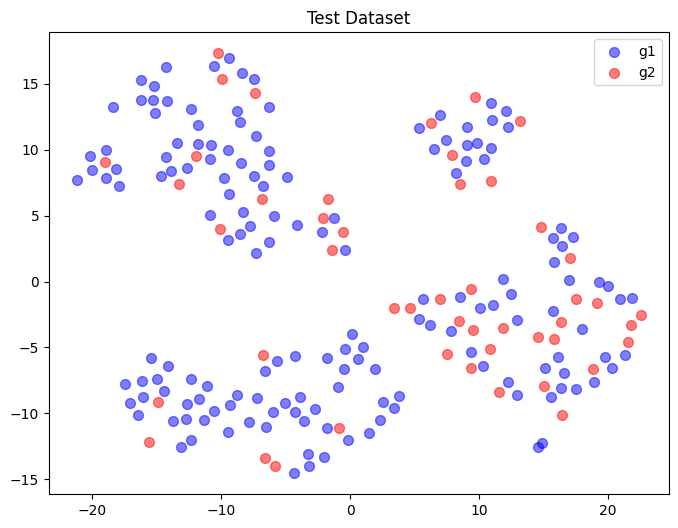

  Metric       Value
0     TP   26.000000
1     TN  104.000000
2     FP   56.000000
3     FN   22.000000
4   sens    0.541667
5   spec    0.650000
6    NPV    0.825397
7    PPV    0.317073
8    acc    0.625000


In [ ]:
import os
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

output_excel_path = '/content/drive/MyDrive/Colab Notebooks/VCMI/monomodal_HGG/ADC_sens1_test_results.xlsx'

def predict_and_visualize(model, test_loader, model_state_dict_path, output_excel_path='test_results.xlsx', random_state=seed):
    model.load_state_dict(torch.load(model_state_dict_path))
    model.eval()

    preds_list = []
    true_list = []
    features = []
    results = []

    with torch.no_grad():
        for path, data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            outputs = model(data)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, 1)

            # 결과 저장
            for i in range(data.size(0)):
                results.append({
                    'File Name': os.path.basename(path[i]),
                    'True Label': label[i].item(),
                    'Predicted Label': preds[i].item(),
                    'Probability Class 0': probabilities[i][0].item(),  # 클래스 0의 확률
                    'Probability Class 1': probabilities[i][1].item(),  # 클래스 1의 확률
                    'Correct': label[i].item() == preds[i].item()
                })

            features.append(outputs.cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
            true_list.extend(label.cpu().numpy())


    features = np.concatenate(features, axis=0)
    true_list = np.array(true_list)
    preds_list = np.array(preds_list)

    # 정확도 및 균형 정확도 출력
    print("Accuracy for each class:")
    accuracy_g1 = accuracy_score(true_list[true_list == 0], preds_list[true_list == 0])
    accuracy_g2 = accuracy_score(true_list[true_list == 1], preds_list[true_list == 1])
    print(f"g1: {accuracy_g1:.4f}")
    print(f"g2: {accuracy_g2:.4f}")

    balanced_accuracy = balanced_accuracy_score(true_list, preds_list)

    # t-SNE 차원 축소 및 시각화
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=20)
    features_2d = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_2d[true_list == 0, 0], features_2d[true_list == 0, 1], s=50, c='blue', label='g1', alpha=0.5)
    plt.scatter(features_2d[true_list == 1, 0], features_2d[true_list == 1, 1], s=50, c='red', label='g2', alpha=0.5)
    plt.title('Test Dataset')
    plt.legend()
    plt.show()

    # 성능 지표 계산
    conf_matrix = confusion_matrix(true_list, preds_list)
    TN = conf_matrix[0][0]
    TP = conf_matrix[1][1]
    FN = conf_matrix[1][0]
    FP = conf_matrix[0][1]
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    NPV = TN / (TN + FN)
    PPV = TP / (TP + FP)
    accuracy = accuracy_score(true_list, preds_list)

    metrics_df = pd.DataFrame({
    'Metric': ['TP', 'TN', 'FP', 'FN', 'sens', 'spec', 'NPV', 'PPV', 'acc'],
    'Value': [TP, TN, FP, FN, sensitivity, specificity, NPV, PPV, accuracy]
    })

    print(metrics_df)

    # 결과를 DataFrame으로 변환하고 Excel로 저장
    results_df = pd.DataFrame(results)
    results_df.to_excel(output_excel_path, index=False)


# 함수 호출 예시
predict_and_visualize(model, test_loader, 'model_state_dict.pth', output_excel_path)
